# MRM and MRMC Confidence Checks

In [1]:
from __future__ import annotations
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))


%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from recourse_methods import mrmc_method
from core import recourse_iterator
from confidence_checks import toy_data, identity_adapter, toy_model, plotting_functions

# Setup the data, model, and adapter

### Get the synthetic data

The synthetic dataset has:
* 1 negatively-classified POI at (-1, 0)
* 1 positively-classified 4-point cluster at (0, 2)
* 1 positively-classified 4-point cluster at (1, 2)

Text(0.5, 1.0, 'Synthetic Dataset')

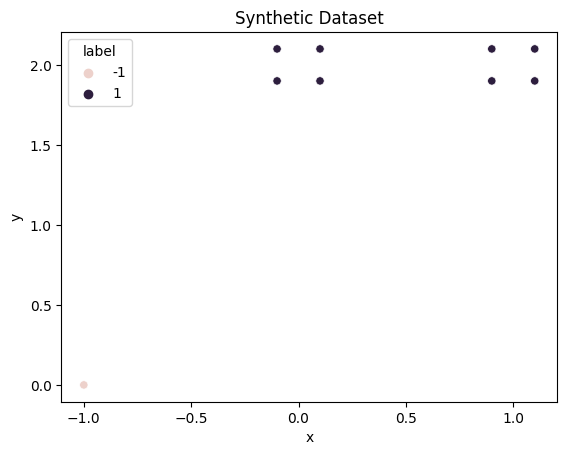

In [2]:
DATASET, DATASET_INFO = toy_data.get_data()
POI = DATASET.drop('label', axis=1).iloc[-1]

sns.scatterplot(x='x', y='y', hue="label", data=DATASET)
plt.title("Synthetic Dataset")

### Create an identity adapter
For ease of debugging, the adapter doesn't transform the data.

In [3]:
ADAPTER = identity_adapter.IdentityAdapter(
    label_column=DATASET_INFO.label_column,
    positive_label=DATASET_INFO.positive_label
).fit(DATASET)

### Create a simple model

There is a low- to high-confidence gradient from (-1, 0) to (1, 2)

<AxesSubplot: title={'center': 'Model Confidence Contours'}, xlabel='x', ylabel='y'>

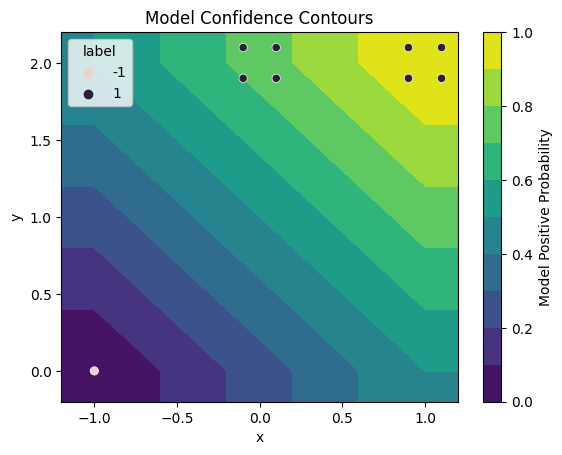

In [4]:
MODEL = toy_model.ToyModel(ADAPTER)


plotting_functions.plot_model_confidence(MODEL)
plt.title('Model Confidence Contours')
sns.scatterplot(x='x', y='y', hue='label', data=DATASET)

# Check MRM

### Check the MRM recourse direction generation

The recourse direction should point between the two clusters

Text(0.5, 1.0, 'Recourse Direction')

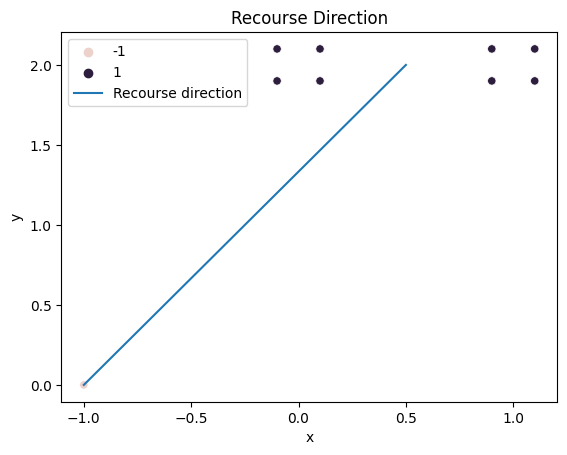

In [7]:
def simple_alpha(dist: np.ndarray) -> np.ndarray:  # passthrough alpha
    return np.ones_like(dist)


mrm = mrmc_method.MRM(
    DATASET,
    ADAPTER,
    alpha=simple_alpha)
x, y = mrm.get_recourse_instructions(POI)
sns.scatterplot(x='x', y='y', data=DATASET, hue='label')
plt.plot([POI.x, POI.x + x], [POI.y, POI.y + y], label='Recourse direction')
plt.legend()
plt.title("Recourse Direction")

### Check the MRM data processing

We expect to see:
1. The single negatively-classified POI at (-1,0) is always filtered out
2. Datapoints below the given confidence threshold are filtered out

With `confidence_threshold = 0.5`, only the POI is removed.

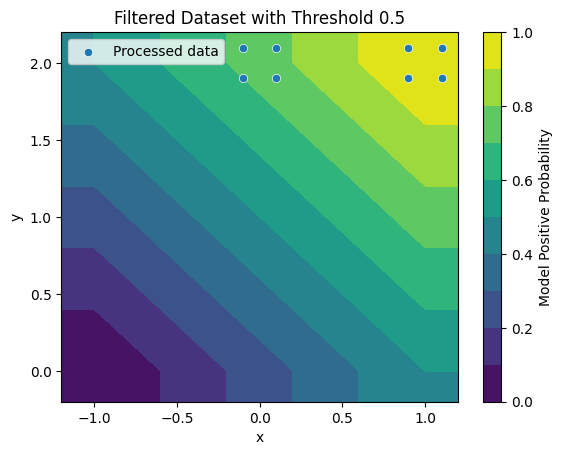

In [8]:
def plot_mrm_filtering(confidence_threshold):
    """Plot the output of mrm._process_data.
    
    Args:
        confidence_threshold: The confidence threshold to process the data with.
    """
    plotting_functions.plot_model_confidence(MODEL)
    plt.title(f'Filtered Dataset with Threshold {confidence_threshold}')
    filtered_dataset = mrm._process_data(DATASET, ADAPTER, confidence_threshold=confidence_threshold, model=MODEL)
    sns.scatterplot(x='x', y='y', data=filtered_dataset, label="Processed data")

plot_mrm_filtering(0.5)

With `confidence_threshold = 0.75`, one point of the left cluster remains.

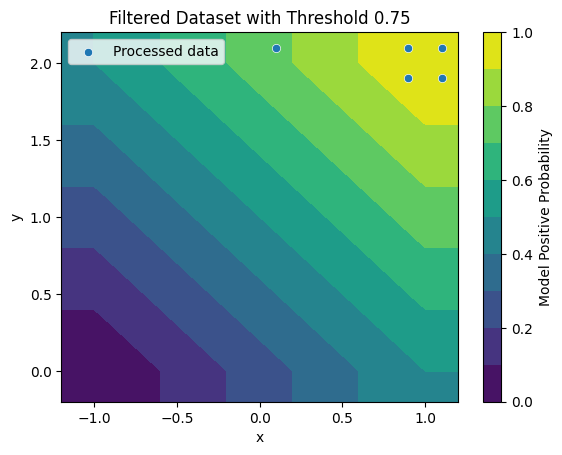

In [9]:
plot_mrm_filtering(0.75)

With `confidence_threshold = 0.9`, only the right cluster remains.

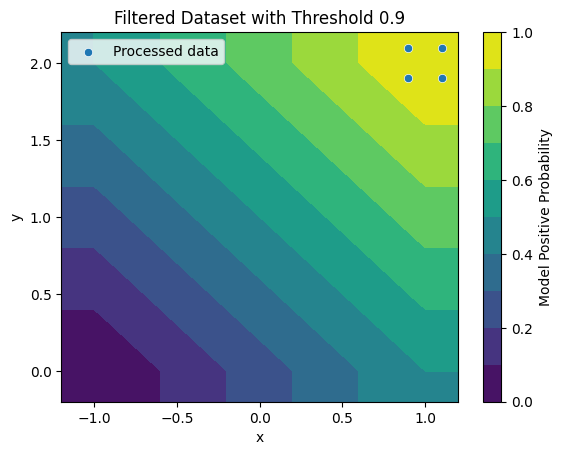

In [10]:
plot_mrm_filtering(0.9)

### Check the MRM recourse directions with confidence filtering

When only the high-confidence right cluster remains, the recourse points directly at it.

Text(0.5, 1.0, 'Recourse with Threshold 0.9')

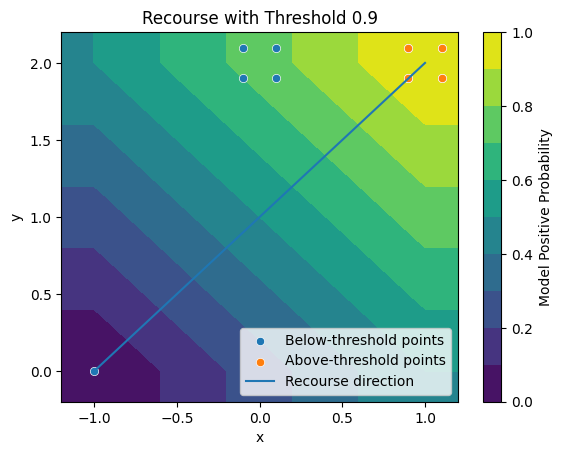

In [11]:
confidence_threshold = 0.9
mrm = mrmc_method.MRM(
    DATASET,
    ADAPTER,
    alpha=simple_alpha,
    confidence_threshold=confidence_threshold,
    model=MODEL)
x, y = mrm.get_recourse_instructions(POI)


plotting_functions.plot_model_confidence(MODEL)

processed_data = mrm._process_data(
    DATASET, ADAPTER, confidence_threshold=confidence_threshold, model=MODEL)
sns.scatterplot(x='x', y='y', data=DATASET, label="Below-threshold points")
sns.scatterplot(x='x', y='y', data=processed_data, label="Above-threshold points")

plt.plot([POI.x, POI.x + x], [POI.y, POI.y + y], label='Recourse direction')

plt.legend()
plt.title(f"Recourse with Threshold {confidence_threshold}")

When the threshold is lowered, a point from the left cluster is added and the recourse points just left of the right cluster.

Text(0.5, 1.0, 'Recourse with Threshold 0.75')

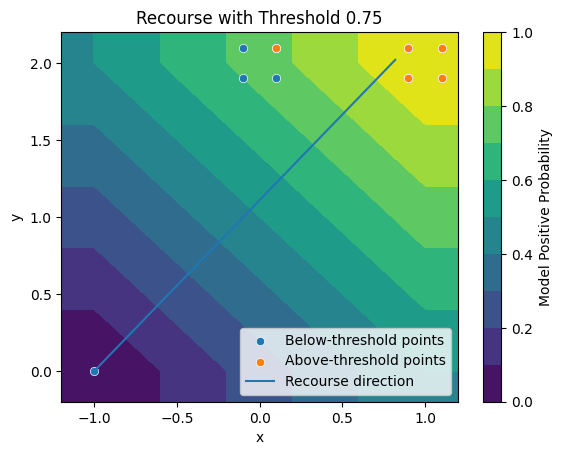

In [12]:
confidence_threshold = 0.75
mrm = mrmc_method.MRM(
    DATASET,
    ADAPTER,
    alpha=simple_alpha,
    confidence_threshold=confidence_threshold,
    model=MODEL)
x, y = mrm.get_recourse_instructions(POI)


plotting_functions.plot_model_confidence(MODEL)

processed_data = mrm._process_data(
    DATASET,
    ADAPTER,
    confidence_threshold=confidence_threshold,
    model=MODEL)
sns.scatterplot(x='x', y='y', data=DATASET, label="Below-threshold points")
sns.scatterplot(x='x', y='y', data=processed_data, label="Above-threshold points")

plt.plot([POI.x, POI.x + x], [POI.y, POI.y + y], label='Recourse direction')
plt.legend()
plt.title(f"Recourse with Threshold {confidence_threshold}")

# Check MRMC

### Check the MRMC recourse directions with confidence filtering

We expect to see MRMC:
1. Filter the dataset by confidence_threshold
2. Create two clusters for the remaining points
3. Generate one direction per cluster

In [13]:
def plot_clusters(clusters, cluster_1_color, cluster_2_color):
    """Plots points labeled according to their cluster.

    Hard-coded to use two clusters.
    
    Args:
        clusters: The Cluster class describing the clusters.
        cluster_1_color: The color to use for the first cluster.
        cluster_2_color: The color to use for the second cluster.
    """

    # Plot all points -- the only points which won't be rerendered are below-
    # threshold points not appearing in a cluster.
    sns.scatterplot(
        x="x", y="y", data=DATASET, label="Below-threshold points", color="red"
    )

    cluster_assignments = clusters.cluster_assignments
    # cluster 1
    cluster_1_indices = cluster_assignments[cluster_assignments.datapoint_cluster == 0].datapoint_index
    cluster_1_df = DATASET.loc[cluster_1_indices]
    sns.scatterplot(x='x', y='y', data=cluster_1_df, label="Cluster 1 points",
        color=cluster_1_color)

    # cluster 2
    cluster_2_indices = cluster_assignments[cluster_assignments.datapoint_cluster == 1].datapoint_index
    cluster_2_df = DATASET.loc[cluster_2_indices]
    sns.scatterplot(x='x', y='y', data=cluster_2_df, label="Cluster 2 points",
        color=cluster_2_color)


def plot_mrmc_directions(confidence_threshold):
    """Generates and plots MRMC recourse directions."""
    mrmc = mrmc_method.MRMC(
        k_directions=2,
        adapter=ADAPTER,
        dataset=DATASET,
        alpha=simple_alpha,
        confidence_threshold=confidence_threshold,
        model=MODEL,
    )
    plotting_functions.plot_model_confidence(MODEL)
    plot_clusters(mrmc.clusters, 'green', 'orange')
    direction_1, direction_2 = mrmc.get_all_recourse_instructions(POI)
    plotting_functions.plot_direction(direction_1, POI, 'green', 1)
    plotting_functions.plot_direction(direction_2, POI, 'orange', 2)
    plt.title(f"MRMC Recourse with Threshold {confidence_threshold}")

When there is no confidence threshold, we expect to see directions towards each cluster.

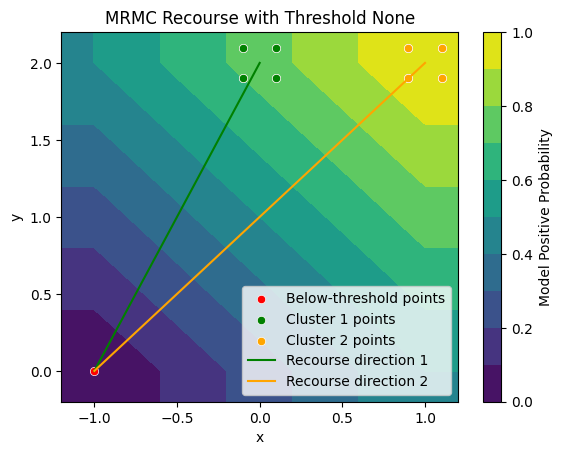

In [14]:
plot_mrmc_directions(None)

When the threshold is raised, a point from the left cluster is added and the left recourse path runs directly through it.

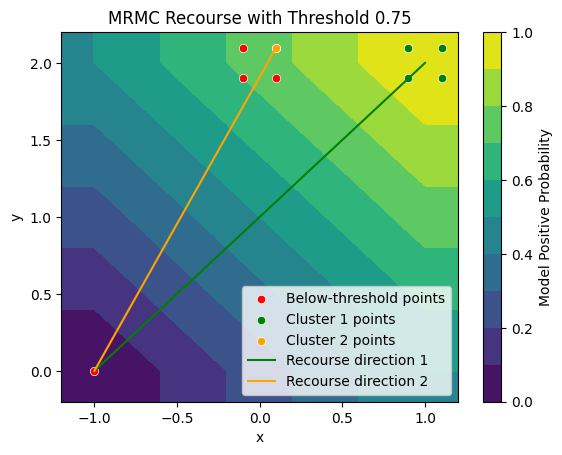

In [15]:
plot_mrmc_directions(0.75)

When the threshold is raised to 0.9, both directions point towards the right cluster.

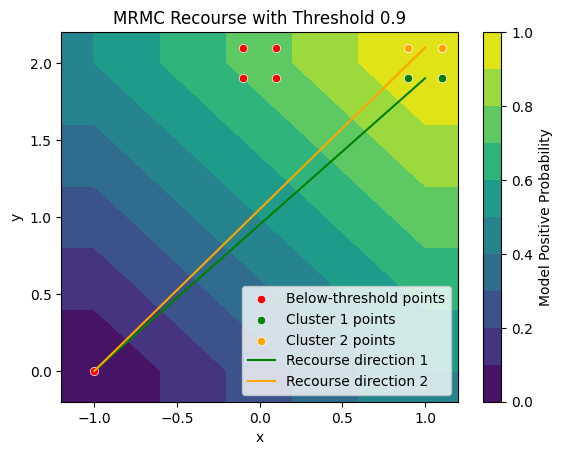

In [16]:
plot_mrmc_directions(0.9)

# Check MRMC Recourse Iteration

In [19]:
def iterate_recourse(
    max_iterations, 
    step_size,
    certainty_cutoff = None,
    confidence_threshold = None,
    model = None,
    perturb_ratio = None,
    rescale_ratio = None):
    """Iterates recourse from MRMC.
    
    Returns:
        A sequence of DataFrame paths and an MRMC Cluster object.
    """
    adapter = identity_adapter.IdentityAdapter(
        label_column=DATASET_INFO.label_column,
        positive_label=DATASET_INFO.positive_label,
        perturb_ratio=perturb_ratio,
        rescale_ratio=rescale_ratio
    ).fit(DATASET)
    rescaler = mrmc_method.get_constant_step_size_rescaler(step_size)
    mrmc = mrmc_method.MRMC(
        k_directions=2,
        adapter=adapter,
        dataset=DATASET,
        alpha=simple_alpha,
        confidence_threshold=confidence_threshold,
        model=model,
        sparsity=1,
        rescale_direction=rescaler
    )
    iterator = recourse_iterator.RecourseIterator(
        recourse_method=mrmc,
        adapter=adapter,
        certainty_cutoff=certainty_cutoff,
        model=model
    )
    paths = iterator.iterate_k_recourse_paths(POI, max_iterations)
    return paths, mrmc.clusters

def plot_recourse_iteration(
    max_iterations, 
    step_size,
    model,
    certainty_cutoff = None,
    confidence_threshold = None,
    perturb_ratio = None,
    rescale_ratio = None):
    """Plots iterated recourse from MRMC.
    
    Args:
        max_iterations: The maximum number of recourse steps to take.
        step_size: The size of each recourse step.
        model: The model to generate recourse for.
        certainty_cutoff: A given model confidence to stop iterating at.
        confidence_threshold: A target model confidence to achieve.
        perturb_ratio: How much to perturb the recourse by.
        rescale_ratio: How much to rescale the recourse by.
    """
    paths, clusters = iterate_recourse(
        max_iterations=max_iterations,
        step_size=step_size,
        certainty_cutoff=certainty_cutoff,
        confidence_threshold=confidence_threshold,
        model=model,
        perturb_ratio=perturb_ratio,
        rescale_ratio=rescale_ratio
    )
    
    plotting_functions.plot_model_confidence(model, xlim=(-1.1, 1.1), ylim=(0,2.2))
    sns.scatterplot(x='x', y='y', data=DATASET, label="Below-threshold points", color='red')

    path_colors = ['green', 'orange']
    plot_clusters(clusters, *path_colors)
    for i, path in enumerate(paths):
        plotting_functions.plot_path(path, path_colors[i], i+1)
    plt.legend()

If no `certainty_cutoff` is set, the paths approach and then jump back and forth over the clusters.

Text(0.5, 1.0, 'MRMC Recourse Iteration')

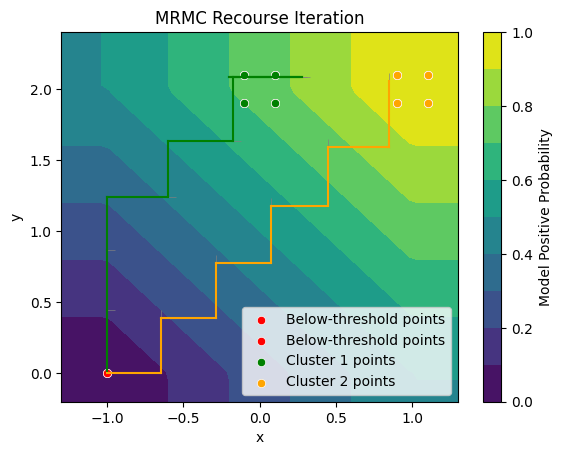

In [25]:
plot_recourse_iteration(
    max_iterations=10,
    step_size=0.5,
    certainty_cutoff=None,
    confidence_threshold=None,
    model=MODEL,
    perturb_ratio=None,
    rescale_ratio=None,
)
plt.title("MRMC Recourse Iteration")

If `certainty_cutoff` is set to 0.8, then:
1. The right cluster path terminates when it reaches the cluster.
2. The left cluster path doesn't terminate because the left cluster has low certainty.

Text(0.5, 1.0, 'Recourse Iteration with Confidence-Based Termination')

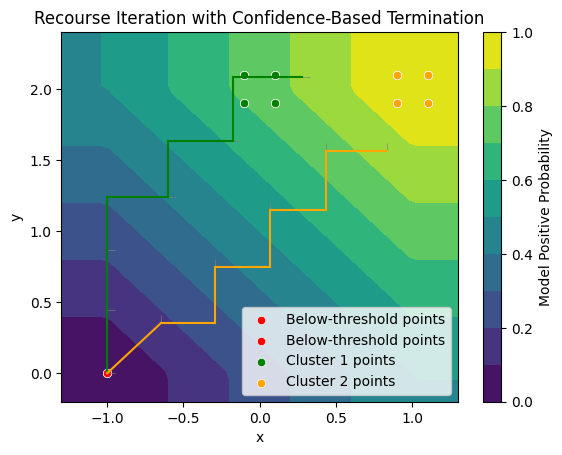

In [23]:
plot_recourse_iteration(
    max_iterations=10,
    step_size=0.5,
    certainty_cutoff=0.8,
    confidence_threshold=None,
    model=MODEL,
    perturb_ratio=None,
    rescale_ratio=None,
)
plt.title("Recourse Iteration with Confidence-Based Termination")

Setting `confidence_threshold` to 0.8 causes both paths to terminate in the right cluster. 

Text(0.5, 1.0, 'Recourse Iteration with Confidence-Based Filtering')

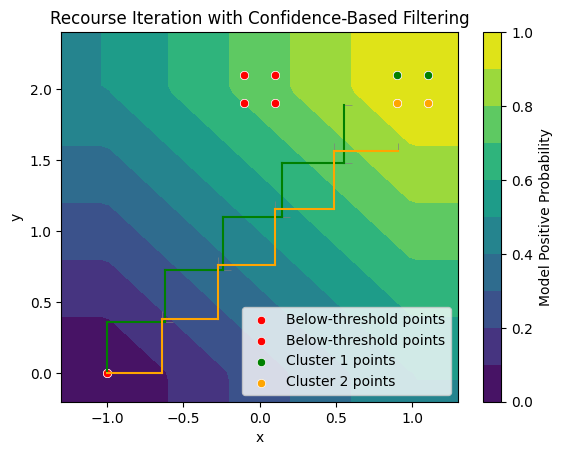

In [22]:
plot_recourse_iteration(
    max_iterations=10,
    step_size=0.5,
    certainty_cutoff=0.8,
    confidence_threshold=0.8,
    model=MODEL,
    perturb_ratio=None,
    rescale_ratio=None,
)
plt.title("Recourse Iteration with Confidence-Based Filtering")

Setting `rescale_ratio` to 0.5 halves the step size.

Text(0.5, 1.0, 'Recourse Iteration with Rescaled Step Size')

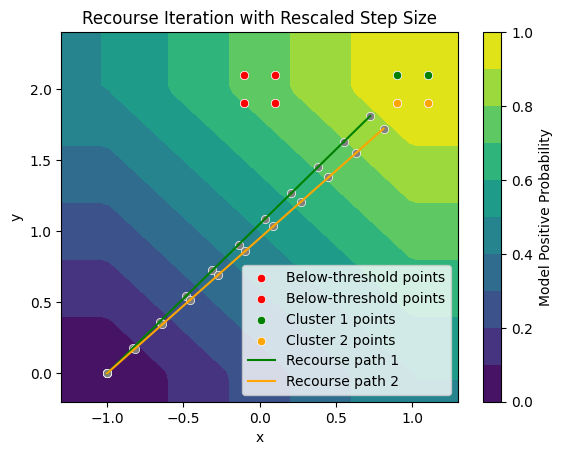

In [37]:
plot_recourse_iteration(
    max_iterations=10,
    step_size=0.5,
    certainty_cutoff=0.8,
    confidence_threshold=0.8,
    model=MODEL,
    perturb_ratio=None,
    rescale_ratio=0.5,
)
plt.title("Recourse Iteration with Rescaled Step Size")

Setting `perturb_ratio` randomly perturbs the direction of each recourse step such that:
1. The perturbations are larger as `perturb_ratio` increases
2. The perturbations don't change the step size


Note that the paths may be perturbed outside of where the model confidence
 contours are rendered, but the confidence is still defined in those areas.

Text(0.5, 1.0, 'Recourse Iteration with Perturbation Ratio 0.1')

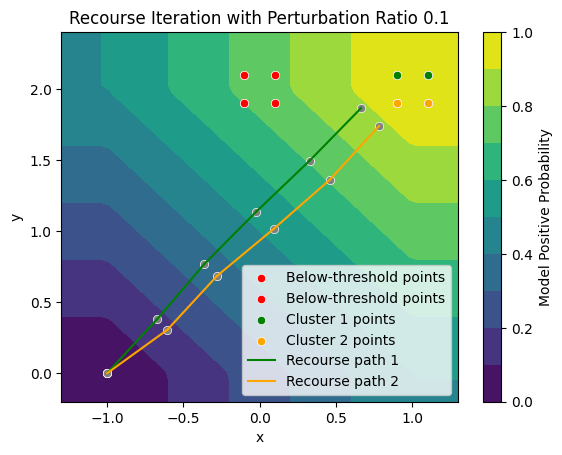

In [38]:
perturb_ratio = 0.1
plot_recourse_iteration(
    max_iterations=10,
    step_size=0.5,
    certainty_cutoff=0.8,
    confidence_threshold=0.8,
    model=MODEL,
    perturb_ratio=perturb_ratio,
    rescale_ratio=None,
)
plt.title(f"Recourse Iteration with Perturbation Ratio {perturb_ratio}")

Text(0.5, 1.0, 'Recourse Iteration with Perturbation Ratio 0.3')

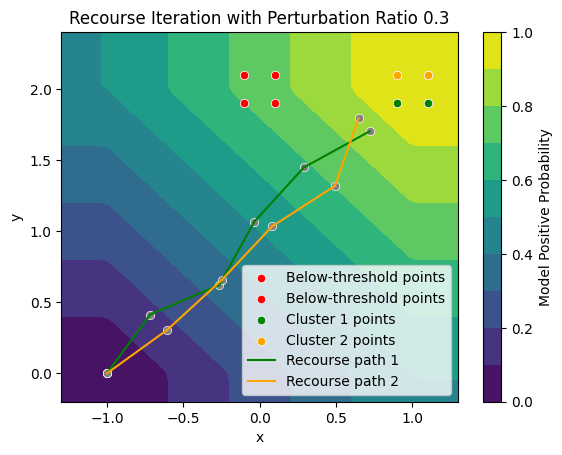

In [39]:
perturb_ratio = 0.3
plot_recourse_iteration(
    max_iterations=10,
    step_size=0.5,
    certainty_cutoff=0.8,
    confidence_threshold=0.8,
    model=MODEL,
    perturb_ratio=perturb_ratio,
    rescale_ratio=None,
)
plt.title(f"Recourse Iteration with Perturbation Ratio {perturb_ratio}")

Text(0.5, 1.0, 'Recourse Iteration with Perturbation Ratio 0.5')

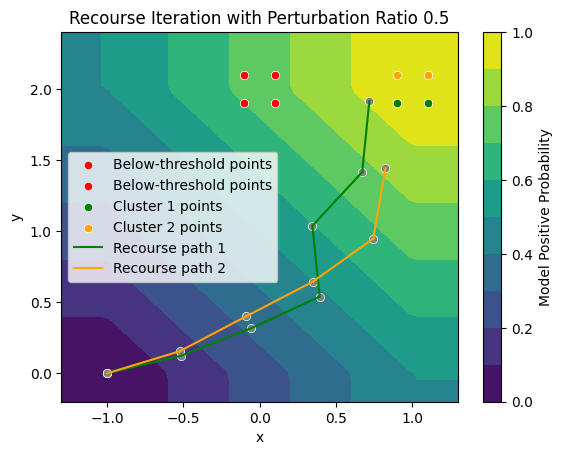

In [40]:
perturb_ratio = 0.5
plot_recourse_iteration(
    max_iterations=10,
    step_size=0.5,
    certainty_cutoff=0.8,
    confidence_threshold=0.8,
    model=MODEL,
    perturb_ratio=perturb_ratio,
    rescale_ratio=None,
)
plt.title(f"Recourse Iteration with Perturbation Ratio {perturb_ratio}")

Text(0.5, 1.0, 'Recourse Iteration with Perturbation Ratio 0.7')

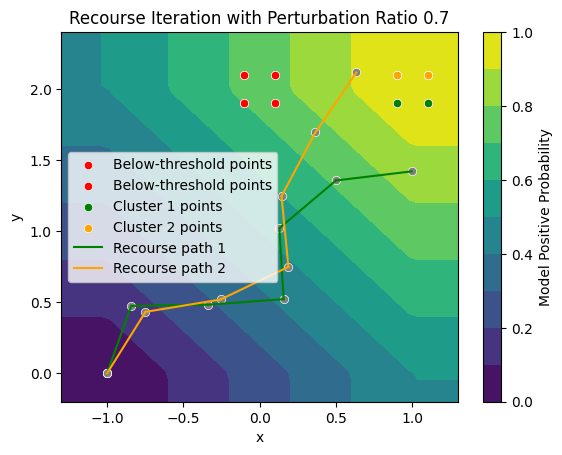

In [41]:
perturb_ratio = 0.7
plot_recourse_iteration(
    max_iterations=10,
    step_size=0.5,
    certainty_cutoff=0.8,
    confidence_threshold=0.8,
    model=MODEL,
    perturb_ratio=perturb_ratio,
    rescale_ratio=None,
)
plt.title(f"Recourse Iteration with Perturbation Ratio {perturb_ratio}")

Text(0.5, 1.0, 'Recourse Iteration with Perturbation Ratio 0.9')

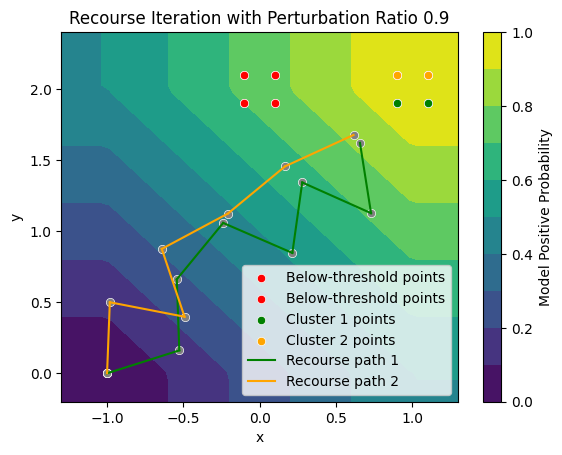

In [42]:
perturb_ratio = 0.9
plot_recourse_iteration(
    max_iterations=10,
    step_size=0.5,
    certainty_cutoff=0.8,
    confidence_threshold=0.8,
    model=MODEL,
    perturb_ratio=perturb_ratio,
    rescale_ratio=None,
)
plt.title(f"Recourse Iteration with Perturbation Ratio {perturb_ratio}")

Text(0.5, 1.0, 'Recourse Iteration with Perturbation Ratio 1.2')

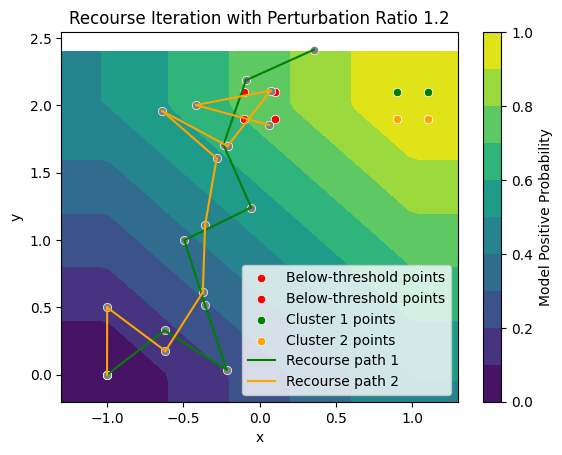

In [43]:
perturb_ratio = 1.2
plot_recourse_iteration(
    max_iterations=10,
    step_size=0.5,
    certainty_cutoff=0.8,
    confidence_threshold=0.8,
    model=MODEL,
    perturb_ratio=perturb_ratio,
    rescale_ratio=None,
)
plt.title(f"Recourse Iteration with Perturbation Ratio {perturb_ratio}")

Text(0.5, 1.0, 'Recourse Iteration with Perturbation Ratio 1.5')

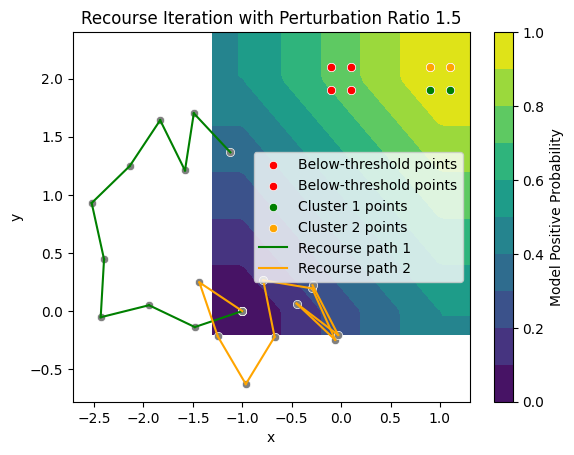

In [44]:
perturb_ratio = 1.5
plot_recourse_iteration(
    max_iterations=10,
    step_size=0.5,
    certainty_cutoff=0.8,
    confidence_threshold=0.8,
    model=MODEL,
    perturb_ratio=perturb_ratio,
    rescale_ratio=None,
)
plt.title(f"Recourse Iteration with Perturbation Ratio {perturb_ratio}")